##Bank Marketing - Predict Subscription to a term deposit

### Section 0 : Import necessary libraries

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import time
import gc
import warnings

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Needed for Deep learning Conv1D using pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold

#import category_encoders as ce

import plotly.graph_objs as go
from tqdm import tqdm

### Section 1 : Extract Data

In [ ]:
# Read data from runtime upload
data = pd.read_csv('bank-additional-full.csv', sep=';')
display('There is {} observations with {} features'.format(data.shape[0], data.shape[1]))

'There is 41188 observations with 21 features'

### Section 2 : Analyze

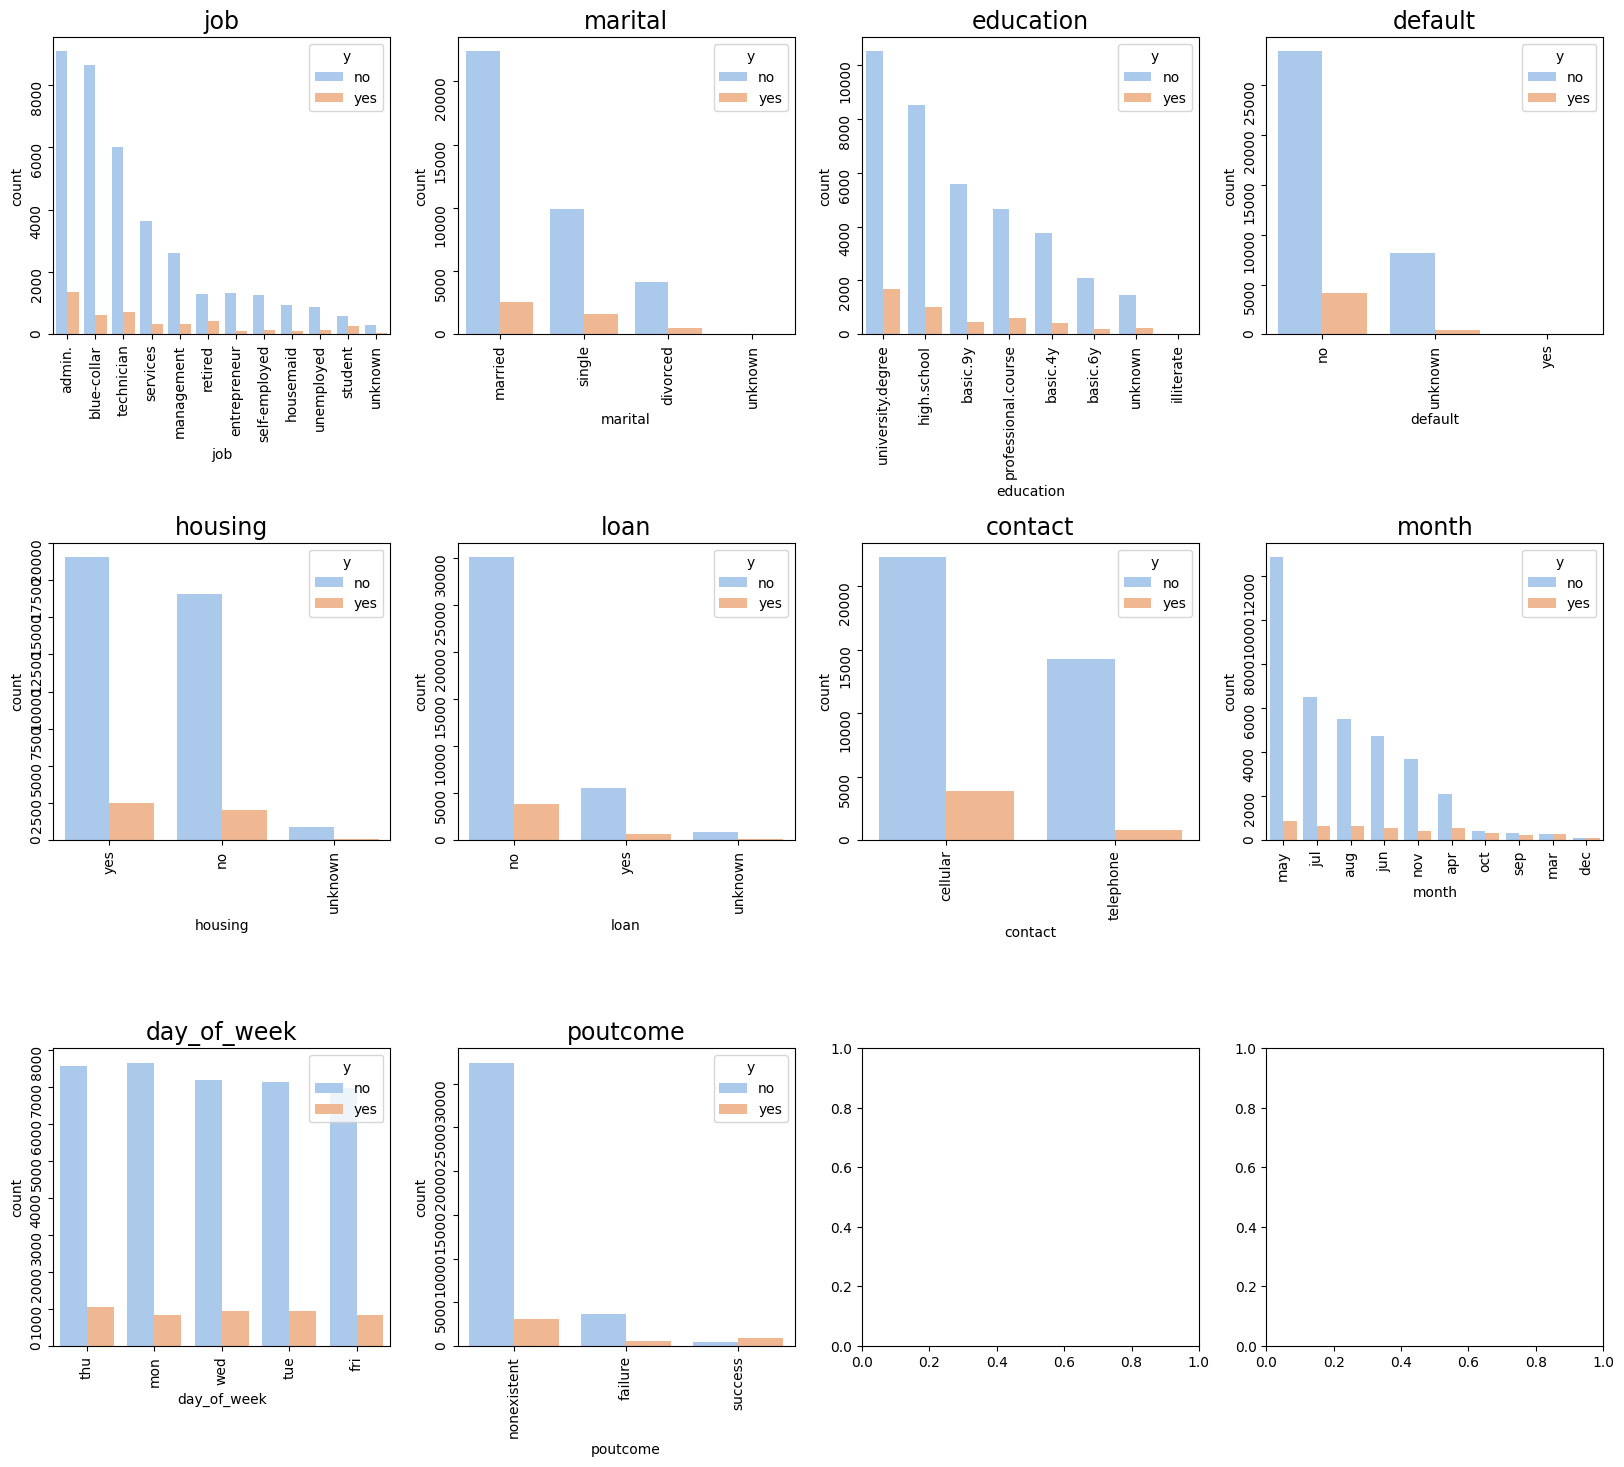

In [ ]:
# Build a function to show distribution of target labels for different values of categorical features
# Reference -- Previous work

fig, ax = plt.subplots(3,4, figsize=(20,17))

cat = data.select_dtypes('object').columns.to_list()
cat = cat[:-1]

ax = ax.ravel()
position = 0

for i in cat:

    order = data[i].value_counts().index
    sns.countplot(data=data, x=i, ax=ax[position], hue='y', palette='pastel', order=order)
    ax[position].tick_params(labelrotation=90)
    ax[position].set_title(i, fontdict={'fontsize':17})

    position += 1

plt.subplots_adjust(hspace=0.7)

plt.show()

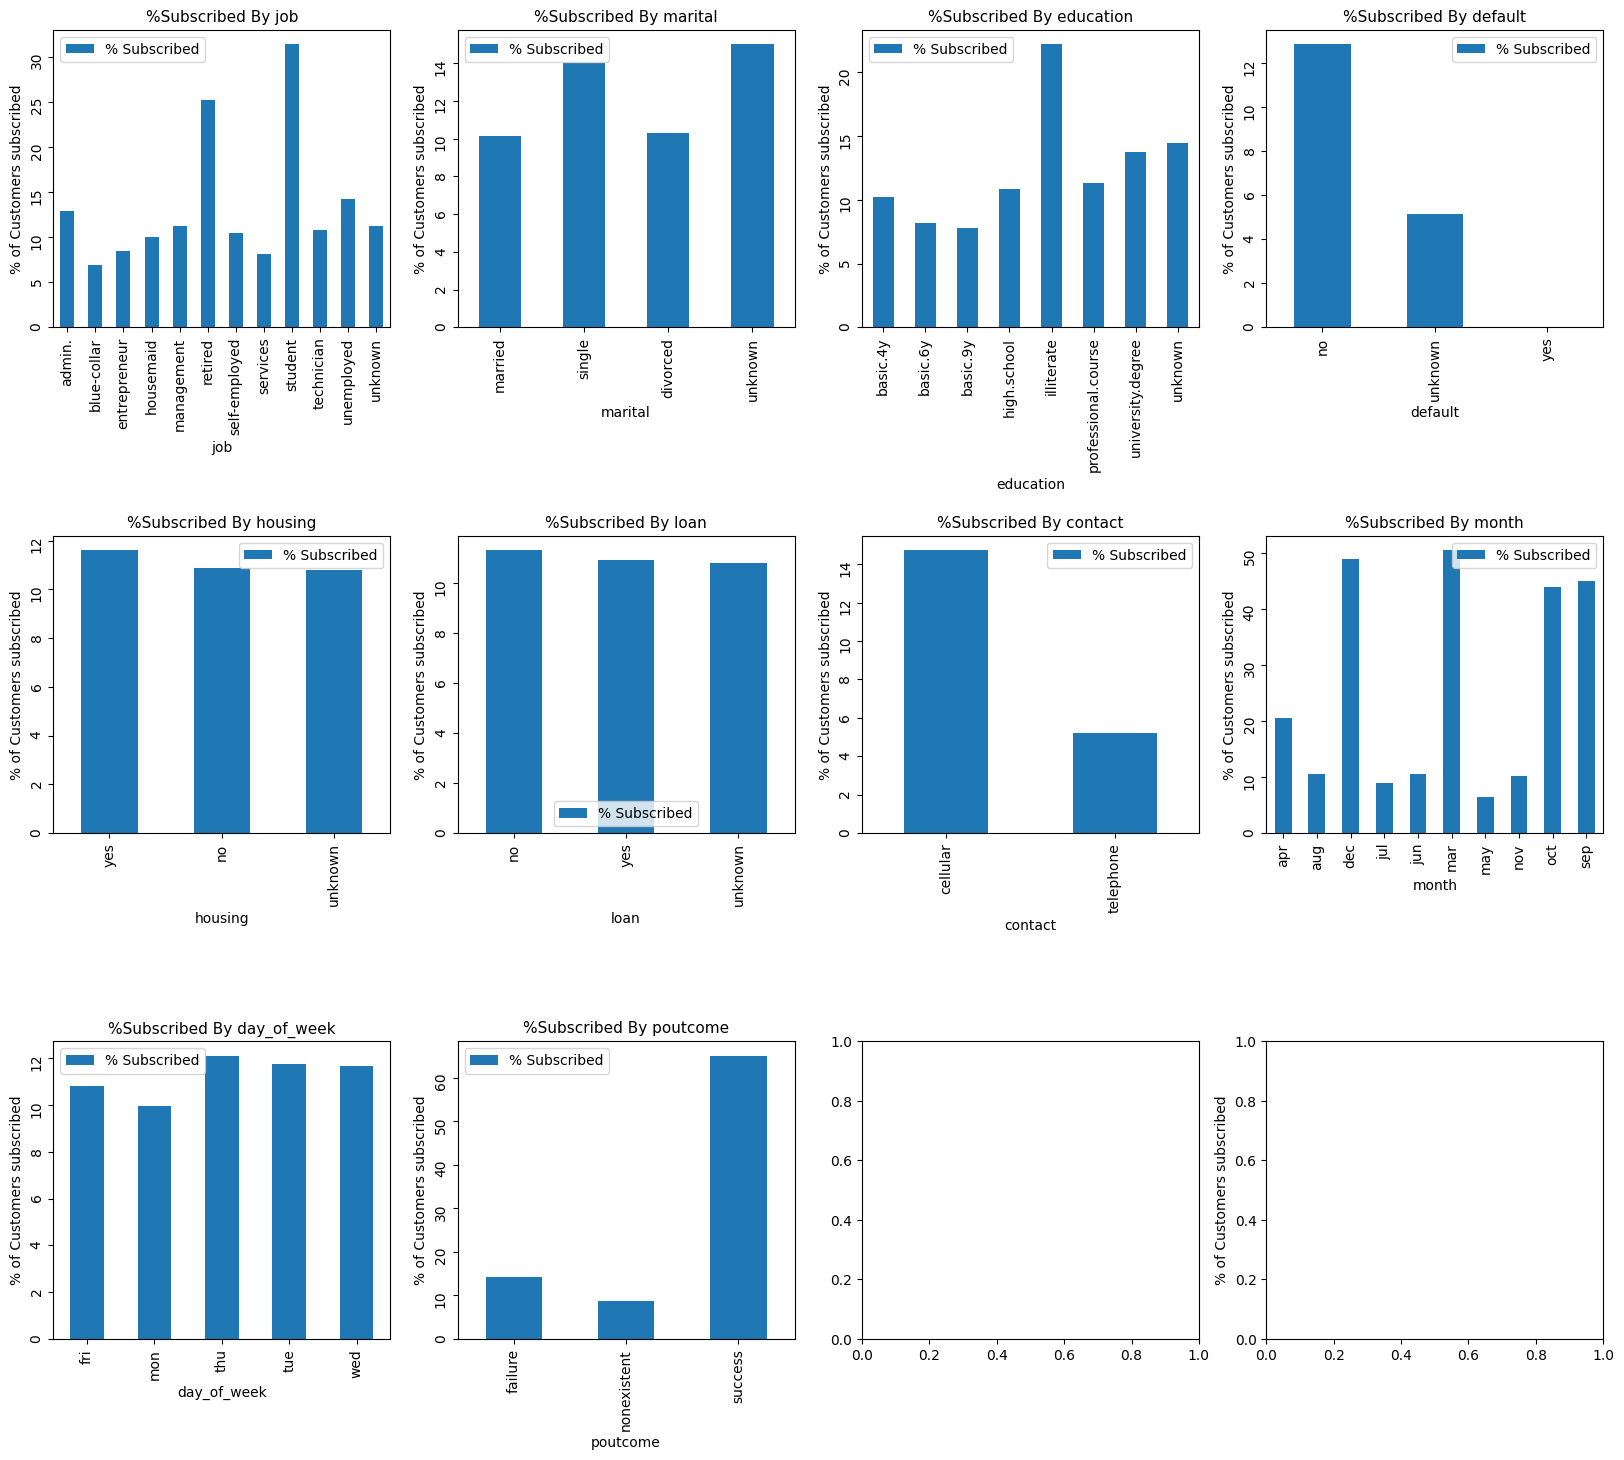

In [ ]:
# Build a function to show percent subscribed for each Categorical feature value
# Look for patterns or values that influence subscription
# ---- New Analysis by %Subscribed -----------------------

fig, ax = plt.subplots(3,4, figsize=(20,17))

cat = data.select_dtypes('object').columns.to_list()
cat = cat[:-1]


ax = ax.ravel()
position = 0

for i in cat:
    # temp df
    temp_1 = pd.DataFrame()
    # count categorical values
    temp_1['% Subscribed'] = data[data['y'] == 'yes'][i].value_counts() *100 /(data[data['y'] == 'no'][i].value_counts() + data[data['y'] == 'yes'][i].value_counts())
    temp_1.plot(kind='bar', ax=ax[position], xlabel=i , ylabel ='% of Customers subscribed')
    plt.ylabel('% of Customers subscribed')
    ax[position].tick_params(labelrotation=90)
    ax[position].set_title('%Subscribed By {}'.format(i), fontdict={'fontsize':11})

    position += 1

plt.subplots_adjust(hspace=0.7)

plt.show()

### Section 3 : Data Cleansing and transformation

In [ ]:
data['month'] = pd.to_datetime(data['month'], format='%b').dt.month
data['month'].value_counts().index

Int64Index([5, 7, 8, 6, 11, 4, 10, 9, 3, 12], dtype='int64')

In [ ]:
d = {'thu':4, 'mon':1, 'wed':3, 'tue':2, 'fri':5}
data['day_of_week'] = data['day_of_week'].map(d)
data['day_of_week'].value_counts().index

Int64Index([4, 1, 3, 2, 5], dtype='int64')

In [ ]:
def pcontacted(x):
    if x == 999:
        return 'no'
    else:
        return 'yes'

data['pdays'] = data['pdays'].apply(pcontacted)
data.rename(columns={"pdays": "bcontacted"}, inplace=True)
data['bcontacted'].value_counts()

no     39673
yes     1515
Name: bcontacted, dtype: int64

In [ ]:
# Drops nulls
def dropnulls(column):

    data[column].replace('unknown', np.nan, inplace=True)
    data.dropna(inplace=True)

dropnulls('job')
dropnulls('marital')
dropnulls('education')
dropnulls('housing')


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38245 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             38245 non-null  int64  
 1   job             38245 non-null  object 
 2   marital         38245 non-null  object 
 3   education       38245 non-null  object 
 4   default         38245 non-null  object 
 5   housing         38245 non-null  object 
 6   loan            38245 non-null  object 
 7   contact         38245 non-null  object 
 8   month           38245 non-null  int64  
 9   day_of_week     38245 non-null  int64  
 10  duration        38245 non-null  int64  
 11  campaign        38245 non-null  int64  
 12  bcontacted      38245 non-null  object 
 13  previous        38245 non-null  int64  
 14  poutcome        38245 non-null  object 
 15  emp.var.rate    38245 non-null  float64
 16  cons.price.idx  38245 non-null  float64
 17  cons.conf.idx   38245 non-null 

### Section 3 : Convert Categorical to Numerical

In [ ]:
data_features = data.iloc[:,:-1]
data_features = pd.get_dummies(data_features)
display(data_features.head(5))

,age,month,day_of_week,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,bcontacted_no,bcontacted_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,5,1,261,1,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,1,1,0,0,1,0
1,57,5,1,149,1,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,1,1,0,0,1,0
2,37,5,1,226,1,0,1.1,93.994,-36.4,4.857,...,1,1,0,0,1,1,0,0,1,0
3,40,5,1,151,1,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,1,1,0,0,1,0
4,56,5,1,307,1,0,1.1,93.994,-36.4,4.857,...,0,0,1,0,1,1,0,0,1,0


In [ ]:
print(data_features.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38245 entries, 0 to 41187
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            38245 non-null  int64  
 1   month                          38245 non-null  int64  
 2   day_of_week                    38245 non-null  int64  
 3   duration                       38245 non-null  int64  
 4   campaign                       38245 non-null  int64  
 5   previous                       38245 non-null  int64  
 6   emp.var.rate                   38245 non-null  float64
 7   cons.price.idx                 38245 non-null  float64
 8   cons.conf.idx                  38245 non-null  float64
 9   euribor3m                      38245 non-null  float64
 10  nr.employed                    38245 non-null  float64
 11  job_admin.                     38245 non-null  uint8  
 12  job_blue-collar                38245 non-null 

### Section 4 : Label Encoding and Scaling

In [ ]:
data_features

,age,month,day_of_week,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,bcontacted_no,bcontacted_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,5,1,261,1,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,1,1,0,0,1,0
1,57,5,1,149,1,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,1,1,0,0,1,0
2,37,5,1,226,1,0,1.1,93.994,-36.4,4.857,...,1,1,0,0,1,1,0,0,1,0
3,40,5,1,151,1,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,1,1,0,0,1,0
4,56,5,1,307,1,0,1.1,93.994,-36.4,4.857,...,0,0,1,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,11,5,334,1,0,-1.1,94.767,-50.8,1.028,...,1,1,0,1,0,1,0,0,1,0
41184,46,11,5,383,1,0,-1.1,94.767,-50.8,1.028,...,0,1,0,1,0,1,0,0,1,0
41185,56,11,5,189,2,0,-1.1,94.767,-50.8,1.028,...,1,1,0,1,0,1,0,0,1,0
41186,44,11,5,442,1,0,-1.1,94.767,-50.8,1.028,...,0,1,0,1,0,1,0,0,1,0


In [ ]:
# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(data_features)


In [ ]:
# Importing LabelEncoder from Sklearn
# library from preprocessing Module.
from sklearn.preprocessing import LabelEncoder

# Creating a instance of label Encoder.
le = LabelEncoder()

# Using .fit_transform function to fit label
# encoder and return encoded label
y = le.fit_transform(data['y'])

# printing label
y

array([0, 0, 0, ..., 0, 1, 0])

### Section 5 : Defining generic function to perform k-fold validation and display results

In [ ]:
def kfold_classify(k,classifier, X, y):

  # Create a k-fold cross-validation object
  kf = KFold(n_splits=k, shuffle=True, random_state=42)

  # Initialize lists to store metrics for each fold
  fold_list = []
  tp_list = []
  fp_list = []
  tn_list = []
  fn_list = []
  tpr_list = []
  fpr_list = []
  accuracy_list = []
  precision_list = []
  recall_list = []
  f1_score_list = []
  auc_list = []
  roc_auc_list = []

  # Perform k-fold cross-validation
  fold = 1

  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the passed classifier
    classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Extract TP, FP, TN, FN from the confusion matrix
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    # Manually calculate TPR (True Positive Rate) and FPR (False Positive Rate)
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)

    # Manually Calculate accuracy, precision, recall, and F1-score
    accuracy = (TP + TN)/(TP + FP + FN + TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = (2 * (precision * recall)) / (precision + recall)

    # Calculate ROC curve and ROC AUC score
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred, average='weighted')

    # Plot the ROC curve for this fold
    plt.plot(fpr, tpr, label=f'Fold {fold}')

    # Store the metrics in the respective lists
    fold_list.append(fold)
    tp_list.append(TP)
    fp_list.append(FP)
    tn_list.append(TN)
    fn_list.append(FN)
    tpr_list.append(TPR)
    fpr_list.append(FPR)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1)
    roc_auc_list.append(roc_auc)

    fold += 1

  # Create a dataframe to store the results
  results_df = pd.DataFrame({
      'Fold': fold_list,
      'TP': tp_list,
		  'FP': fp_list,
		  'TN': tn_list,
		  'FN': fn_list,
		  'TPR': tpr_list,
		  'FPR': fpr_list,
		  'Accuracy': accuracy_list,
		  'Precision': precision_list,
		  'Recall': recall_list,
		  'F1-Score': f1_score_list,
		  'ROC_AUC': roc_auc_list
      })

  # Set plot settings
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guess')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc='lower right')
  plt.show()

  return results_df



# Function to display metrics in tabular form

def display_results(results_df):

  # Transpose the results to calculate row-wise average
  results_transpose = results_df.transpose()
  results_transpose['Avg'] = results_transpose.mean(axis=1)

  # Transpose it back to make the metrics as columns
  results = results_transpose.transpose()
  results.iloc[:, 5:] = results.iloc[:, 5:].round(3)

  # Removing unnecessary decimal places
  for i in ['Fold','TP','FP','TN','FN']:
    results[i] = results[i].apply(lambda x: '{:.0f}'.format(x))

  return results


### Section 6: Algorithm 1 - Random Forest Classifier

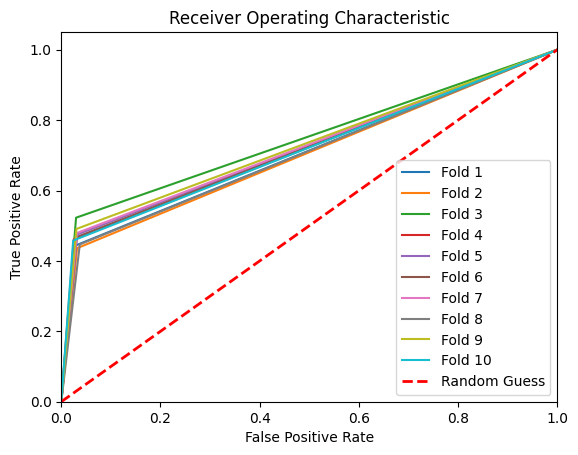

In [ ]:
# Create a RandomForest Classifier
classifier = RandomForestClassifier(criterion='gini',
									n_estimators=200,
									random_state=1,
									n_jobs=2)

# Call the kfold_classify function with 10 folds
results_df = kfold_classify(10, classifier, X, y)

In [ ]:
# Display the metrics in tabular form
results = display_results(results_df)
results

,Fold,TP,FP,TN,FN,TPR,FPR,Accuracy,Precision,Recall,F1-Score,ROC_AUC
0,1,193,97,3293,242,0.444,0.029,0.911,0.666,0.444,0.532,0.708
1,2,184,108,3295,238,0.436,0.032,0.910,0.630,0.436,0.515,0.702
2,3,229,101,3286,209,0.523,0.030,0.919,0.694,0.523,0.596,0.747
3,4,192,86,3323,224,0.462,0.025,0.919,0.691,0.462,0.553,0.718
4,5,211,109,3272,233,0.475,0.032,0.911,0.659,0.475,0.552,0.721
5,6,203,105,3285,231,0.468,0.031,0.912,0.659,0.468,0.547,0.718
6,7,196,107,3308,213,0.479,0.031,0.916,0.647,0.479,0.551,0.724
7,8,190,127,3272,235,0.447,0.037,0.905,0.599,0.447,0.512,0.705
8,9,188,105,3336,195,0.491,0.031,0.922,0.642,0.491,0.556,0.730
9,10,207,81,3291,245,0.458,0.024,0.915,0.719,0.458,0.559,0.717


### Section 7: Algorithm 2 - K Nearest Neighbour

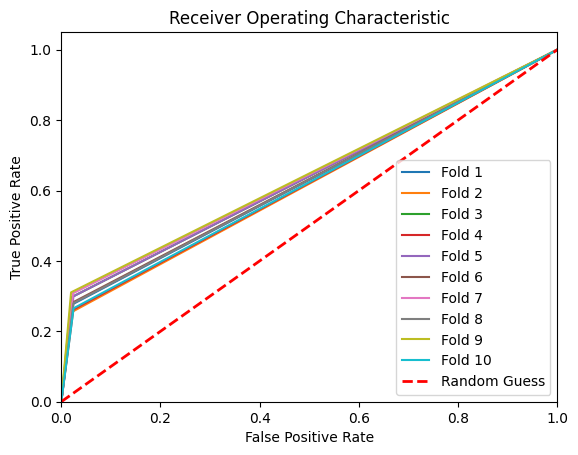

In [ ]:
# Create a RandomForest Classifier
classifier = KNeighborsClassifier(n_neighbors=9)

# Call the kfold_classify function with 10 folds
results_df = kfold_classify(10, classifier, X, y)

In [ ]:
# Display the metrics in tabular form
results = display_results(results_df)
results

,Fold,TP,FP,TN,FN,TPR,FPR,Accuracy,Precision,Recall,F1-Score,ROC_AUC
0,1,121,83,3307,314,0.278,0.024,0.896,0.593,0.278,0.379,0.627
1,2,108,77,3326,314,0.256,0.023,0.898,0.584,0.256,0.356,0.617
2,3,130,70,3317,308,0.297,0.021,0.901,0.650,0.297,0.408,0.638
3,4,109,83,3326,307,0.262,0.024,0.898,0.568,0.262,0.359,0.619
4,5,133,83,3298,311,0.300,0.025,0.897,0.616,0.300,0.403,0.638
5,6,122,74,3316,312,0.281,0.022,0.899,0.622,0.281,0.387,0.630
6,7,126,81,3334,283,0.308,0.024,0.905,0.609,0.308,0.409,0.642
7,8,119,83,3316,306,0.280,0.024,0.898,0.589,0.280,0.380,0.628
8,9,119,68,3373,264,0.311,0.020,0.913,0.636,0.311,0.418,0.645
9,10,120,84,3288,332,0.265,0.025,0.891,0.588,0.265,0.366,0.620


### Section 8: Algorithm 3 - Decision Tree

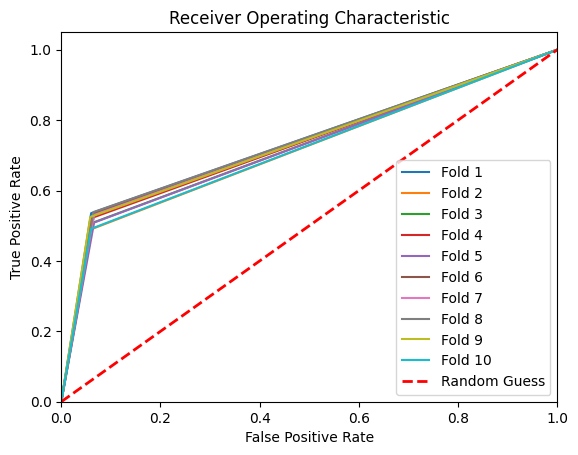

In [ ]:
# Create a RandomForest Classifier
classifier = DecisionTreeClassifier(criterion='entropy')

# Call the kfold_classify function with 10 folds
results_df = kfold_classify(10, classifier, X, y)

In [ ]:
# Display the metrics in tabular form
results = display_results(results_df)
results

,Fold,TP,FP,TN,FN,TPR,FPR,Accuracy,Precision,Recall,F1-Score,ROC_AUC
0,1,233,204,3186,202,0.536,0.060,0.894,0.533,0.536,0.534,0.738
1,2,207,210,3193,215,0.491,0.062,0.889,0.496,0.491,0.493,0.714
2,3,223,219,3168,215,0.509,0.065,0.887,0.505,0.509,0.507,0.722
3,4,217,207,3202,199,0.522,0.061,0.894,0.512,0.522,0.517,0.730
4,5,226,224,3157,218,0.509,0.066,0.884,0.502,0.509,0.506,0.721
5,6,232,226,3164,202,0.535,0.067,0.888,0.507,0.535,0.520,0.734
6,7,217,225,3190,192,0.531,0.066,0.891,0.491,0.531,0.510,0.732
7,8,229,221,3178,196,0.539,0.065,0.891,0.509,0.539,0.523,0.737
8,9,201,201,3240,182,0.525,0.058,0.900,0.500,0.525,0.512,0.733
9,10,222,202,3170,230,0.491,0.060,0.887,0.524,0.491,0.507,0.716


### Section 9: Algorithm 4 - Deep Learning Conv1d

Processing fold 1...
X_train shape before unqueeze torch.Size([34420, 46])...
X_train shape after unqueeze torch.Size([34420, 1, 46])...
X_train shape with permute torch.Size([34420, 46, 1])...
Processing fold 2...
X_train shape before unqueeze torch.Size([34420, 46])...
X_train shape after unqueeze torch.Size([34420, 1, 46])...
X_train shape with permute torch.Size([34420, 46, 1])...
Processing fold 3...
X_train shape before unqueeze torch.Size([34420, 46])...
X_train shape after unqueeze torch.Size([34420, 1, 46])...
X_train shape with permute torch.Size([34420, 46, 1])...
Processing fold 4...
X_train shape before unqueeze torch.Size([34420, 46])...
X_train shape after unqueeze torch.Size([34420, 1, 46])...
X_train shape with permute torch.Size([34420, 46, 1])...
Processing fold 5...
X_train shape before unqueeze torch.Size([34420, 46])...
X_train shape after unqueeze torch.Size([34420, 1, 46])...
X_train shape with permute torch.Size([34420, 46, 1])...
Processing fold 6...
X_train s

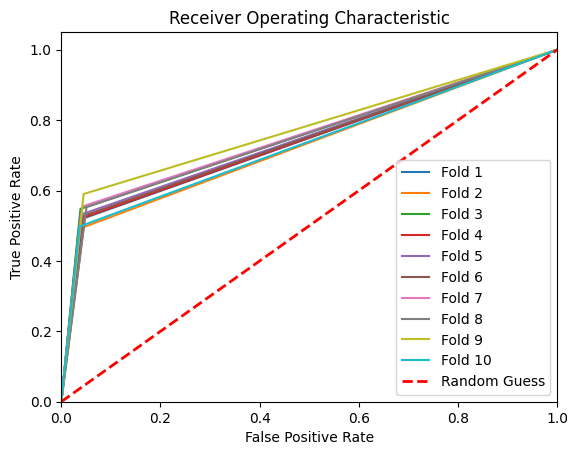

In [ ]:
#Define k fold
k = 10

# Create a k-fold cross-validation object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

#Initialize lists
fold_list = []
tp_list = []
fp_list = []
tn_list = []
fn_list = []
tpr_list = []
fpr_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []
auc_list = []
roc_auc_list = []

fold = 1

# Define your Conv1D model
class BankModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BankModel, self).__init__()
        self.conv1d = nn.Conv1d(input_size, hidden_size, kernel_size=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=1)
        self.relu2 = nn.ReLU()
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = torch.mean(x, dim=2)
        x = self.fc(x)
        return x

# Set hyperparameters
input_size = 46  # The number of features in your data
hidden_size = 64
num_classes = 2
learning_rate = 0.01
batch_size = 64
num_epochs = 50

#K-fold loop starts
for train_index, test_index in kf.split(X):

  print(f"Processing fold {fold}...")

  # Split data into train and test sets
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  # Convert data to tensors
  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.long)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.long)

  #Print shape before unsqueeze
  print(f"X_train shape before unqueeze {X_train.shape}...")

  # Add an extra dimension to the input tensors
  X_train = X_train.unsqueeze(1)  # (batch_size, channels, sequence_length)
  X_test = X_test.unsqueeze(1)  # (batch_size, channels, sequence_length)

  #Print shape after unsqueeze
  print(f"X_train shape after unqueeze {X_train.shape}...")

  # Create model, loss function, and optimizer
  model = BankModel(input_size, hidden_size, num_classes)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  #Print shape with permute to match Conv1D input
  print(f"X_train shape with permute {X_train.permute(0, 2, 1).shape}...")

  # Training loop
  for epoch in range(num_epochs):
      model.train()
      optimizer.zero_grad()
      outputs = model(X_train.permute(0, 2, 1))  # Permute dimensions for Conv1D input
      loss = criterion(outputs, y_train)
      loss.backward()
      optimizer.step()

  # Evaluation
  model.eval()

  with torch.no_grad():
      outputs = model(X_test.permute(0, 2, 1))  # Permute dimensions for Conv1D input
      _, predicted = torch.max(outputs.data, 1)
      # Calculate evaluation metrics
      cm = confusion_matrix(y_test, predicted)
      # Extract TP, FP, TN, FN
      TP = cm[1, 1]
      FP = cm[0, 1]
      TN = cm[0, 0]
      FN = cm[1, 0]

      # Calculate TPR (True Positive Rate) and FPR (False Positive Rate)
      TPR = TP / (TP + FN)
      FPR = FP / (FP + TN)

      # Calculate accuracy, precision, recall, and F1-score
      accuracy = (TP + TN)/(TP + FP + FN + TN)
      precision = TP / (TP + FP)
      recall = TP / (TP + FN)
      f1 = (2 * (precision * recall)) / (precision + recall)

      # Calculate ROC curve and ROC AUC score
      fpr, tpr, _ = roc_curve(y_test, predicted)
      roc_auc = roc_auc_score(y_test, predicted)

      # Plot the ROC curve for this fold
      plt.plot(fpr, tpr, label=f'Fold {fold}')

      # Store the metrics in the respective lists
      fold_list.append(fold)
      tp_list.append(TP)
      fp_list.append(FP)
      tn_list.append(TN)
      fn_list.append(FN)
      tpr_list.append(TPR)
      fpr_list.append(FPR)
      accuracy_list.append(accuracy)
      precision_list.append(precision)
      recall_list.append(recall)
      f1_score_list.append(f1)
      roc_auc_list.append(roc_auc)

  fold += 1

# Create a dataframe to store the results
results_df = pd.DataFrame({
    'Fold': fold_list,
    'TP': tp_list,
		'FP': fp_list,
		'TN': tn_list,
		'FN': fn_list,
		'TPR': tpr_list,
		'FPR': fpr_list,
		'Accuracy': accuracy_list,
		'Precision': precision_list,
		'Recall': recall_list,
		'F1-Score': f1_score_list,
		'ROC_AUC': roc_auc_list
    })

# Set plot settings
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Display the metrics in tabular form
results = display_results(results_df)
results

,Fold,TP,FP,TN,FN,TPR,FPR,Accuracy,Precision,Recall,F1-Score,ROC_AUC
0,1,225,127,3263,210,0.517,0.037,0.912,0.639,0.517,0.572,0.740
1,2,207,118,3285,215,0.491,0.035,0.913,0.637,0.491,0.554,0.728
2,3,240,131,3256,198,0.548,0.039,0.914,0.647,0.548,0.593,0.755
3,4,218,162,3247,198,0.524,0.048,0.906,0.574,0.524,0.548,0.738
4,5,236,132,3249,208,0.532,0.039,0.911,0.641,0.532,0.581,0.746
5,6,229,149,3241,205,0.528,0.044,0.907,0.606,0.528,0.564,0.742
6,7,227,147,3268,182,0.555,0.043,0.914,0.607,0.555,0.580,0.756
7,8,235,173,3226,190,0.553,0.051,0.905,0.576,0.553,0.564,0.751
8,9,226,155,3286,157,0.590,0.045,0.918,0.593,0.590,0.592,0.773
9,10,225,124,3248,227,0.498,0.037,0.908,0.645,0.498,0.562,0.731
